<a href="https://colab.research.google.com/github/riponalmamun/Customer-Retention-Prediction/blob/main/Performance_Comparison_With_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ============================================================
# 📘 CUSTOMER CHURN PREDICTION PIPELINE WITH OPTUNA TUNING
# ============================================================
 Author: Md Ripon Al Mamun
Description: Full ML pipeline for customer churn prediction
using multiple classifiers (Logistic, RandomForest, XGBoost,
LightGBM, MLP) with hyperparameter tuning via Optuna.
# ============================================================

In [2]:
# =====================
# 1️⃣ IMPORT LIBRARIES
# =====================
%pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings("ignore")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.8 MB/s eta 0:00:00


# =====================
# 2️⃣ LOAD DATASET
# =====================

In [3]:
file_path = "/content/dataset.csv"
data = pd.read_csv(file_path)
print("✅ Dataset Loaded Successfully!")
print("Shape:", data.shape)
display(data.head())

✅ Dataset Loaded Successfully!
Shape: (1000, 15)


,Customer_ID,Age,Gender,Annual_Income,Total_Spend,Years_as_Customer,Num_of_Purchases,Average_Transaction_Amount,Num_of_Returns,Num_of_Support_Contacts,Satisfaction_Score,Last_Purchase_Days_Ago,Email_Opt_In,Promotion_Response,Target_Churn
0,1,62,Other,45.15,5892.58,5,22,453.80,2,0,3,129,True,Responded,True
1,2,65,Male,79.51,9025.47,13,77,22.90,2,2,3,227,False,Responded,False
2,3,18,Male,29.19,618.83,13,71,50.53,5,2,2,283,False,Responded,True
3,4,21,Other,79.63,9110.30,3,33,411.83,5,3,5,226,True,Ignored,True
4,5,21,Other,77.66,5390.88,15,43,101.19,3,0,5,242,False,Unsubscribed,False


# ===========================
# 3️⃣ DATA INSPECTION
# ===========================


📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_ID                 1000 non-null   int64  
 1   Age                         1000 non-null   int64  
 2   Gender                      1000 non-null   object 
 3   Annual_Income               1000 non-null   float64
 4   Total_Spend                 1000 non-null   float64
 5   Years_as_Customer           1000 non-null   int64  
 6   Num_of_Purchases            1000 non-null   int64  
 7   Average_Transaction_Amount  1000 non-null   float64
 8   Num_of_Returns              1000 non-null   int64  
 9   Num_of_Support_Contacts     1000 non-null   int64  
 10  Satisfaction_Score          1000 non-null   int64  
 11  Last_Purchase_Days_Ago      1000 non-null   int64  
 12  Email_Opt_In                1000 non-null   bool   
 13  Promotion_Respons

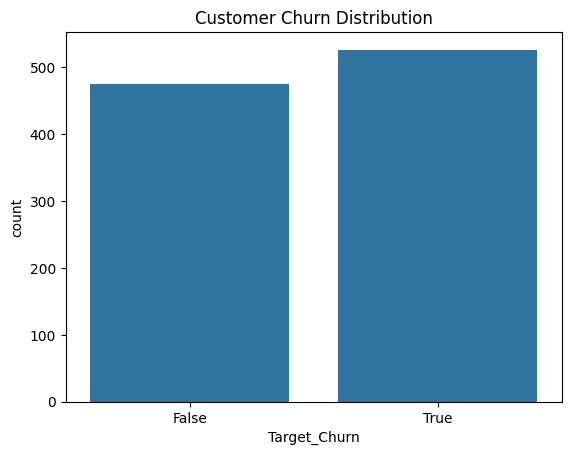

In [4]:
print("\n📊 Dataset Info:")
print(data.info())

print("\n🔍 Missing Values:")
print(data.isnull().sum())

print("\n📈 Target Distribution:")
sns.countplot(x="Target_Churn", data=data)
plt.title("Customer Churn Distribution")
plt.show()

# ===========================
# 4️⃣ DATA PREPROCESSING
# ===========================

In [5]:
# Encode categorical features
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Split features and target
X = data.drop("Target_Churn", axis=1)
y = data["Target_Churn"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\n✅ Data split completed!")

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ==============================
# 5️⃣ BASELINE MODEL TRAINING
# ==============================
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "MLP": MLPClassifier(max_iter=300, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results.append([
        name,
        accuracy_score(y_test, preds),
        precision_score(y_test, preds),
        recall_score(y_test, preds),
        f1_score(y_test, preds),
        roc_auc_score(y_test, preds)
    ])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print("\n📋 Baseline Model Performance:")
display(results_df)


✅ Data split completed!
[LightGBM] [Info] Number of positive: 421, number of negative: 379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526250 -> initscore=0.105097
[LightGBM] [Info] Start training from score 0.105097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
4,MLP,0.510,0.530973,0.571429,0.550459,0.506767
3,LightGBM,0.495,0.518868,0.523810,0.521327,0.493484
2,XGBoost,0.495,0.520408,0.485714,0.502463,0.495489
0,LogisticRegression,0.465,0.493151,0.685714,0.573705,0.453383
1,RandomForest,0.455,0.481818,0.504762,0.493023,0.452381


# ==================================================
# 6️⃣ OPTUNA HYPERPARAMETER TUNING (Example: MLP)
# ==================================================

In [6]:
def objective(trial):
    """Objective function for Optuna hyperparameter optimization."""
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_layer_sizes = tuple(trial.suggest_int(f"n_units_l{i}", 32, 256) for i in range(n_layers))
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)

    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        max_iter=500,
        random_state=42
    )

    # 5-fold stratified cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        scores.append(accuracy_score(y_val, preds))

    return np.mean(scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=30)

print("\n🎯 Best Hyperparameters Found:")
display(study.best_trial.params)

[I 2025-10-15 06:15:24,621] A new study created in memory with name: no-name-a91bc515-25ed-42d2-8ec1-0be030ab1f57
[I 2025-10-15 06:16:24,282] Trial 0 finished with value: 0.49375 and parameters: {'n_layers': 2, 'n_units_l0': 245, 'n_units_l1': 196, 'learning_rate_init': 0.0006251373574521745, 'alpha': 2.9380279387035334e-05}. Best is trial 0 with value: 0.49375.
[I 2025-10-15 06:16:28,909] Trial 1 finished with value: 0.4937499999999999 and parameters: {'n_layers': 1, 'n_units_l0': 45, 'learning_rate_init': 0.003967605077052989, 'alpha': 0.0006358358856676254}. Best is trial 0 with value: 0.49375.
[I 2025-10-15 06:17:45,307] Trial 2 finished with value: 0.5050000000000001 and parameters: {'n_layers': 3, 'n_units_l0': 36, 'n_units_l1': 250, 'n_units_l2': 219, 'learning_rate_init': 4.335281794951564e-05, 'alpha': 3.511356313970405e-05}. Best is trial 2 with value: 0.5050000000000001.
[I 2025-10-15 06:17:51,343] Trial 3 finished with value: 0.48875 and parameters: {'n_layers': 1, 'n_units


🎯 Best Hyperparameters Found:


{'n_layers': 3,
 'n_units_l0': 227,
 'n_units_l1': 235,
 'n_units_l2': 118,
 'learning_rate_init': 1.7816774153275627e-05,
 'alpha': 1.6750052086651473e-05}

# ===========================================
# 7️⃣ TRAIN MLP WITH OPTUNA BEST PARAMETERS
# ===========================================


🚀 OPTUNA-TUNED MLP PERFORMANCE:
Accuracy: 0.5350
Precision: 0.5500
Recall: 0.6286
F1-Score: 0.5867
ROC-AUC: 0.5301


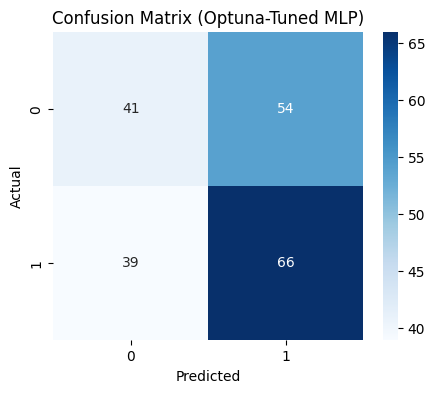

In [7]:
best_params = study.best_trial.params
best_hidden_layers = tuple(best_params[f"n_units_l{i}"] for i in range(best_params['n_layers']))

best_mlp = MLPClassifier(
    hidden_layer_sizes=best_hidden_layers,
    learning_rate_init=best_params['learning_rate_init'],
    alpha=best_params['alpha'],
    max_iter=500,
    random_state=42
)

best_mlp.fit(X_train, y_train)
preds = best_mlp.predict(X_test)

# Evaluate performance
metrics = {
    "Accuracy": accuracy_score(y_test, preds),
    "Precision": precision_score(y_test, preds),
    "Recall": recall_score(y_test, preds),
    "F1-Score": f1_score(y_test, preds),
    "ROC-AUC": roc_auc_score(y_test, preds)
}

print("\n🚀 OPTUNA-TUNED MLP PERFORMANCE:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Optuna-Tuned MLP)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()